In [8]:
import numpy as np
import time
import os
import pickle
from numba import jit, types
from numba.typed import Dict
from collections import Counter, defaultdict
import math
from itertools import groupby
import matplotlib.pyplot as plt

@jit(nopython=True)
def simulate_trajectory_core(rate_matrix, state_to_metastate_array, max_length, initial_state, 
                           exit_rates, transition_matrices):
    """
    Optimized core simulation loop using Numba JIT compilation.
    """
    n_states = rate_matrix.shape[0]
    
    # Pre-allocate arrays with estimated size
    trajectory = np.zeros(max_length, dtype=np.int32)
    times = np.zeros(max_length, dtype=np.float64)
    
    current_state = initial_state
    trajectory[0] = current_state
    times[0] = 0.0
    time_elapsed = 0.0
    current_length = 1
    
    # Track metastate transitions
    current_metastate = state_to_metastate_array[current_state]
    time_entered_current_metastate = 0.0
    
    # Pre-allocate waiting times storage (using lists would be better but numba limitations)
    # We'll return raw data and process it outside
    metastate_changes = np.zeros(max_length, dtype=np.int32)  # -1 = no change, else metastate index
    waiting_times_raw = np.zeros(max_length, dtype=np.float64)
    num_metastate_records = 0
    
    # Use pre-computed exit rates and transition matrices
    while current_length < max_length:
        exit_rate = exit_rates[current_state]
        
        if exit_rate <= 0:
            break
        
        # Generate waiting time using inverse transform sampling
        waiting_time = -np.log(np.random.random()) / exit_rate
        time_elapsed += waiting_time
        
        # Sample next state using pre-computed transition probabilities
        rand_val = np.random.random()
        cumsum = 0.0
        next_state = current_state  # fallback
        
        for j in range(n_states):
            if j != current_state:
                cumsum += transition_matrices[current_state, j]
                if rand_val <= cumsum:
                    next_state = j
                    break
        
        # Check if we're transitioning to a different metastate
        next_metastate = state_to_metastate_array[next_state]
        
        # If transitioning to a different metastate, record time spent in current metastate
        if next_metastate != current_metastate:
            time_in_current_metastate = time_elapsed - time_entered_current_metastate
            metastate_changes[num_metastate_records] = current_metastate
            waiting_times_raw[num_metastate_records] = time_in_current_metastate
            num_metastate_records += 1
            time_entered_current_metastate = time_elapsed
        
        # Update state and trajectory
        current_state = next_state
        current_metastate = next_metastate
        trajectory[current_length] = current_state
        times[current_length] = time_elapsed
        current_length += 1
    
    return (trajectory[:current_length], times[:current_length], 
            metastate_changes[:num_metastate_records], waiting_times_raw[:num_metastate_records])

def precompute_transition_data(rate_matrix):
    """
    Pre-compute exit rates and transition probability matrices for faster simulation.
    """
    n_states = rate_matrix.shape[0]
    exit_rates = np.zeros(n_states)
    transition_matrices = np.zeros((n_states, n_states))
    
    for i in range(n_states):
        exit_rate = -rate_matrix[i, i]
        exit_rates[i] = exit_rate
        
        if exit_rate > 0:
            # Pre-compute transition probabilities
            transition_rates = rate_matrix[:, i].copy()
            transition_rates[i] = 0
            transition_matrices[i, :] = transition_rates / exit_rate
    
    return exit_rates, transition_matrices

def process_metastate_waiting_times(metastate_changes, waiting_times_raw, metastate_groups):
    """
    Process the raw metastate data into the final format.
    """
    # Create reverse mapping from metastate index to name
    metastate_names = list(metastate_groups.keys())
    
    # Initialize waiting times storage
    waiting_times_by_metastate = {}
    for metastate_name in metastate_names:
        waiting_times_by_metastate[metastate_name] = []
    
    # Process the recorded metastate changes
    for i in range(len(metastate_changes)):
        metastate_idx = metastate_changes[i]
        waiting_time = waiting_times_raw[i]
        
        # Find metastate name from index
        metastate_name = metastate_names[metastate_idx] if metastate_idx < len(metastate_names) else None
        
        if metastate_name and waiting_time > 0:
            waiting_times_by_metastate[metastate_name].append(waiting_time)
    
    # Calculate total time in each metastate
    time_in_metastates = {metastate: np.sum(waiting_list) 
                         for metastate, waiting_list in waiting_times_by_metastate.items()}
    
    # Count metastate transitions
    metastate_transition_count = len(metastate_changes)
    
    return waiting_times_by_metastate, time_in_metastates, metastate_transition_count


def simulate_single_trajectory(rate_matrix, metastate_groups, max_length=1000, initial_state=0, save_path=None):
    """
    Optimized simulation of a continuous-time Markov chain.
    
    Major optimizations:
    1. JIT compilation of core simulation loop
    2. Pre-computation of transition probabilities
    3. Vectorized metastate analysis
    4. Reduced memory allocations
    5. Efficient data structures
    """
    
    # Convert rate matrix to numpy array if needed
    rate_matrix = np.array(rate_matrix, dtype=np.float64)
    n_states = rate_matrix.shape[0]
    
    # Validate rate matrix (simplified validation for performance)
    if rate_matrix.shape[0] != rate_matrix.shape[1]:
        raise ValueError("Rate matrix must be square")
    
    # Quick validation of diagonal elements
    for i in range(n_states):
        off_diagonal_sum = np.sum(rate_matrix[:, i]) - rate_matrix[i, i]
        expected_diagonal = -off_diagonal_sum
        if not np.isclose(rate_matrix[i, i], expected_diagonal, rtol=1e-10):
            print(f"Warning: Rate matrix may not be properly normalized at state {i}")
    
    # Create optimized state to metastate mapping
    state_to_metastate = {}
    metastate_names = list(metastate_groups.keys())
    
    for metastate_idx, (metastate_name, state_list) in enumerate(metastate_groups.items()):
        for state_idx in state_list:
            if state_idx >= n_states:
                raise ValueError(f"State index {state_idx} exceeds matrix size")
            state_to_metastate[state_idx] = metastate_idx  # Use index for numba
    
    # Create array version for numba
    state_to_metastate_array = np.array([state_to_metastate.get(i, 0) for i in range(n_states)])
    
    # Pre-compute transition data for faster simulation
    print("Pre-computing transition data...")
    exit_rates, transition_matrices = precompute_transition_data(rate_matrix)
    
    print(f"Starting optimized simulation with {n_states} states, {len(metastate_names)} metastates")
    print(f"Initial state: {initial_state}")
    
    start_time = time.time()
    
    # Run optimized core simulation
    trajectory, times, metastate_changes, waiting_times_raw = simulate_trajectory_core(
        rate_matrix, state_to_metastate_array, max_length, initial_state,
        exit_rates, transition_matrices
    )
    
    simulation_time = time.time() - start_time
    print(f"Core simulation completed in {simulation_time:.2f} seconds")
    
    # Process metastate data
    print("Processing metastate transitions...")
    analysis_start = time.time()
    
    waiting_times_by_metastate, time_in_metastates, metastate_transition_count = process_metastate_waiting_times(
        metastate_changes, waiting_times_raw, metastate_groups
    )
    
    analysis_time = time.time() - analysis_start
    print(f"Analysis completed in {analysis_time:.2f} seconds")
    
    # Print results
    final_time = times[-1] if len(times) > 0 else 0
    print(f"\nSimulation complete. Total time: {final_time:.2f}")
    print(f"Trajectory length: {len(trajectory)}")
    
    for metastate_name in metastate_names:
        total_time = time_in_metastates.get(metastate_name, 0)
        num_visits = len(waiting_times_by_metastate.get(metastate_name, []))
        avg_waiting_time = total_time / num_visits if num_visits > 0 else 0
        print(f"Metastate {metastate_name}: {total_time:.2f} total time, {num_visits} visits, {avg_waiting_time:.2f} avg per visit")
        
        # Show first few waiting times for debugging
        if num_visits > 0:
            sample_times = waiting_times_by_metastate[metastate_name][:5]
            print(f"  First few waiting times: {[f'{t:.3f}' for t in sample_times]}")
    
    print(f"Total metastate transitions: {metastate_transition_count}")
    print(f"Total execution time: {simulation_time + analysis_time:.2f} seconds")
    
    # Create simulation data dictionary
    simulation_data = {
        'trajectory': trajectory.tolist(),
        'times': times.tolist(),
        'waiting_times_by_metastate': waiting_times_by_metastate,
        'metastate_transition_count': metastate_transition_count,
        'parameters': {
            'rate_matrix': rate_matrix.tolist(),
            'metastate_groups': metastate_groups,
            'max_length': max_length,
            'initial_state': initial_state,
            'final_time': final_time
        },
        'performance': {
            'simulation_time': simulation_time,
            'analysis_time': analysis_time,
            'total_time': simulation_time + analysis_time
        }
    }
    
    # Save if path provided
    if save_path:
        save_directory = os.path.dirname(save_path)
        if save_directory and not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        with open(save_path, 'wb') as f:
            pickle.dump(simulation_data, f)
        print(f"Data saved to {save_path}")
    
    return trajectory, times, waiting_times_by_metastate, time_in_metastates, metastate_transition_count


def export_waiting_times_for_mathematica_v2(simulation_data, output_path, format_type='mathematica'):
    """
    Export waiting times data in a format that can be easily imported into Mathematica.
    
    Parameters:
    - simulation_data: dict returned by simulate_single_trajectory() or loaded from pickle
    - output_path: path where to save the exported file
    - format_type: 'mathematica' for .m file format
    """
    
    # Extract data - handle both old and new data structure
    if 'waiting_times_by_metastate' in simulation_data:
        waiting_times_by_metastate = simulation_data['waiting_times_by_metastate']
    elif 'waiting_times_by_superstate' in simulation_data:
        # For backward compatibility with old data
        waiting_times_by_metastate = simulation_data['waiting_times_by_superstate']
    else:
        raise KeyError("No waiting times data found in simulation_data")
    
    parameters = simulation_data['parameters']
    metadata = simulation_data.get('metadata', {})

    # Create output directory if it doesn't exist
    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if format_type.lower() == 'mathematica':
        # Export as Mathematica .m file
        with open(output_path, 'w') as f:
            f.write('(* Generalized Markov Chain Waiting Times Data *)\n')
            f.write(f'(* Generated on: {time.strftime("%Y-%m-%d %H:%M:%S")} *)\n\n')

            # Write parameters
            f.write('(* Parameters *)\n')
            f.write('parameters = Association[\n')
            param_items = list(parameters.items())
            for i, (key, value) in enumerate(param_items):
                # Handle different parameter types
                if key == 'rate_matrix':
                    # Convert numpy array to list if needed and format for Mathematica
                    if hasattr(value, 'tolist'):
                        matrix_data = value.tolist()
                    else:
                        matrix_data = value
                    
                    # Format rate matrix for Mathematica (use curly braces)
                    matrix_str = '{\n'
                    for row_idx, row in enumerate(matrix_data):
                        matrix_str += '    {' + ', '.join([f'{float(val):.6f}' for val in row]) + '}'
                        if row_idx < len(matrix_data) - 1:
                            matrix_str += ','
                        matrix_str += '\n'
                    matrix_str += '  }'
                    value_str = matrix_str
                elif key == 'metastate_groups' and isinstance(value, dict):
                    # Format metastate groups for Mathematica using Association
                    groups_str = 'Association[\n'
                    group_items = list(value.items())
                    for j, (group_name, state_list) in enumerate(group_items):
                        state_list_str = '{' + ', '.join([str(s) for s in state_list]) + '}'
                        comma = ',' if j < len(group_items) - 1 else ''
                        groups_str += f'    "{group_name}" -> {state_list_str}{comma}\n'
                    groups_str += '  ]'
                    value_str = groups_str
                elif isinstance(value, str):
                    value_str = f'"{value}"'
                elif isinstance(value, (int, float)):
                    value_str = str(float(value))
                else:
                    value_str = str(value)
                
                comma = ',' if i < len(param_items) - 1 else ''
                f.write(f'  "{key}" -> {value_str}{comma}\n')
            f.write('];\n\n')

            # Write waiting times
            f.write('(* Waiting Times by Metastate *)\n')
            f.write('waitingTimes = Association[\n')
            metastate_items = list(waiting_times_by_metastate.items())
            for i, (metastate, wait_times) in enumerate(metastate_items):
                f.write(f'  "{metastate}" -> {{')
                for j, wt in enumerate(wait_times):
                    if j > 0:
                        f.write(', ')
                    if j % 10 == 0 and j > 0:
                        f.write('\n    ')
                    f.write(f'{float(wt):.6f}')
                f.write('}')
                comma = ',' if i < len(metastate_items) - 1 else ''
                f.write(f'{comma}\n')
            f.write('];\n\n')

            # Calculate and write time fractions
            f.write('(* Time Fractions by Metastate *)\n')
            total_time = sum(sum(wait_times) for wait_times in waiting_times_by_metastate.values())
            f.write(f'totalSimulationTime = {float(total_time):.6f};\n\n')
            
            f.write('timeFractions = Association[\n')
            for i, (metastate, wait_times) in enumerate(metastate_items):
                metastate_total_time = sum(wait_times)
                fraction = metastate_total_time / total_time if total_time > 0 else 0
                comma = ',' if i < len(metastate_items) - 1 else ''
                f.write(f'  "{metastate}" -> {float(fraction):.6f}{comma}\n')
            f.write('];\n\n')

            # Write summary statistics
            f.write('(* Summary Statistics *)\n')
            f.write('summaryStats = Association[\n')
            for i, (metastate, wait_times) in enumerate(metastate_items):
                if wait_times:
                    mean_wt = np.mean(wait_times)
                    std_wt = np.std(wait_times)
                    median_wt = np.median(wait_times)
                    min_wt = np.min(wait_times)
                    max_wt = np.max(wait_times)
                    count = len(wait_times)
                    comma = ',' if i < len(metastate_items) - 1 else ''
                    f.write(f'  "{metastate}" -> Association[\n')
                    f.write(f'    "mean" -> {float(mean_wt):.6f},\n')
                    f.write(f'    "std" -> {float(std_wt):.6f},\n')
                    f.write(f'    "median" -> {float(median_wt):.6f},\n')
                    f.write(f'    "min" -> {float(min_wt):.6f},\n')
                    f.write(f'    "max" -> {float(max_wt):.6f},\n')
                    f.write(f'    "count" -> {count}\n')
                    f.write(f'  ]{comma}\n')
            f.write('];\n\n')

            # Write additional analysis data
            f.write('(* Additional Analysis Data *)\n')
            if 'trajectory' in simulation_data:
                trajectory = simulation_data['trajectory']
                f.write(f'trajectoryLength = {len(trajectory)};\n')
                if 'trajectory' in simulation_data:
                    trajectory = simulation_data['trajectory']
                    f.write('trajectory = {\n')
                    for i, state in enumerate(trajectory):
                        f.write(f'{state}')
                        if i < len(trajectory) - 1:
                            f.write(', ')
                        if (i + 1) % 20 == 0:
                            f.write('\n')
                    f.write('};\n\n')
                
                # Count state visits
                state_counts = {}
                for state in trajectory:
                    state_counts[state] = state_counts.get(state, 0) + 1
                
                f.write('stateVisitCounts = Association[\n')
                state_items = list(state_counts.items())
                for i, (state, count) in enumerate(state_items):
                    comma = ',' if i < len(state_items) - 1 else ''
                    f.write(f'  {state} -> {count}{comma}\n')
                f.write('];\n\n')
            
            if 'times' in simulation_data:
                times = simulation_data['times']
                f.write('(* Time Points for Trajectory *)\n')
                f.write('times = {\n')
                for i, t in enumerate(times):
                    f.write(f'{float(t):.6f}')
                    if i < len(times) - 1:
                        f.write(', ')
                    if (i + 1) % 20 == 0:
                        f.write('\n')
                f.write('};\n\n')
                

            if 'metastate_transition_count' in simulation_data:
                f.write(f'metastateTransitionCount = {simulation_data["metastate_transition_count"]};\n\n')

            # Write metadata if available
            if metadata:
                f.write('(* Metadata *)\n')
                f.write('metadata = Association[\n')
                metadata_items = list(metadata.items())
                for i, (key, value) in enumerate(metadata_items):
                    if isinstance(value, list):
                        joined_vals = ", ".join([f'"{v}"' for v in value])
                        value_str = f'{{{joined_vals}}}'
                    else:
                        value_str = f'"{value}"'
                    comma = ',' if i < len(metadata_items) - 1 else ''
                    f.write(f'  "{key}" -> {value_str}{comma}\n')
                f.write('];\n\n')

            # Write helper functions for Mathematica analysis
            f.write('(* Helper Functions for Analysis *)\n')
            f.write('getWaitingTimesForMetastate[metastateName_String] := waitingTimes[metastateName];\n')
            f.write('getStatisticsForMetastate[metastateName_String] := summaryStats[metastateName];\n')
            f.write('getAllMetastateNames[] := Keys[waitingTimes];\n')
            f.write('getTotalSimulationTime[] := parameters["final_time"];\n')
            f.write('getRateMatrix[] := parameters["rate_matrix"];\n')
            f.write('getMetastateGroups[] := parameters["metastate_groups"];\n\n')
            
            # Add time fraction analysis functions
            f.write('(* Time Fraction Analysis Functions *)\n')
            f.write('getTimeFractionForMetastate[metastateName_String] := timeFractions[metastateName];\n')
            f.write('getAllTimeFractions[] := timeFractions;\n\n')
            
            f.write('(* Calculate statistics of waiting time contributions for a metastate *)\n')
            f.write('getWaitingTimeStatistics[metastateName_String] := Module[{times, totalTime, fractions},\n')
            f.write('  times = getWaitingTimesForMetastate[metastateName];\n')
            f.write('  totalTime = Total[Flatten[Values[waitingTimes]]];\n')
            f.write('  fractions = times/totalTime;\n')
            f.write('  Association[\n')
            f.write('    "meanFraction" -> Mean[fractions],\n')
            f.write('    "varianceFraction" -> Variance[fractions],\n')
            f.write('    "stdFraction" -> StandardDeviation[fractions],\n')
            f.write('    "totalFraction" -> Total[fractions],\n')
            f.write('    "count" -> Length[times]\n')
            f.write('  ]\n')
            f.write('];\n\n')
            
            f.write('(* Calculate bootstrap confidence intervals for time fractions *)\n')
            f.write('bootstrapTimeFraction[metastateName_String, nBootstrap_Integer : 1000, confidenceLevel_ : 0.95] := Module[\n')
            f.write('  {times, allTimes, bootstrapFractions, alpha, lowerQuantile, upperQuantile},\n')
            f.write('  times = getWaitingTimesForMetastate[metastateName];\n')
            f.write('  allTimes = Flatten[Values[waitingTimes]];\n')
            f.write('  (* Generate bootstrap samples *)\n')
            f.write('  bootstrapFractions = Table[\n')
            f.write('    Module[{resampledTimes, resampledAllTimes},\n')
            f.write('      resampledTimes = RandomChoice[times, Length[times]];\n')
            f.write('      resampledAllTimes = RandomChoice[allTimes, Length[allTimes]];\n')
            f.write('      Total[resampledTimes]/Total[resampledAllTimes]\n')
            f.write('    ],\n')
            f.write('    {nBootstrap}\n')
            f.write('  ];\n')
            f.write('  alpha = 1 - confidenceLevel;\n')
            f.write('  lowerQuantile = Quantile[bootstrapFractions, alpha/2];\n')
            f.write('  upperQuantile = Quantile[bootstrapFractions, 1 - alpha/2];\n')
            f.write('  Association[\n')
            f.write('    "mean" -> Mean[bootstrapFractions],\n')
            f.write('    "variance" -> Variance[bootstrapFractions],\n')
            f.write('    "confidenceInterval" -> {lowerQuantile, upperQuantile},\n')
            f.write('    "confidenceLevel" -> confidenceLevel\n')
            f.write('  ]\n')
            f.write('];\n\n')
            
            f.write('(* Summary table of all metastate time fractions with statistics *)\n')
            f.write('getTimeFractionSummary[] := Module[{metastates, summary},\n')
            f.write('  metastates = getAllMetastateNames[];\n')
            f.write('  summary = Association @@ Table[\n')
            f.write('    metastate -> Association[\n')
            f.write('      "observedFraction" -> getTimeFractionForMetastate[metastate],\n')
            f.write('      "waitingTimeStats" -> getWaitingTimeStatistics[metastate]\n')
            f.write('    ],\n')
            f.write('    {metastate, metastates}\n')
            f.write('  ];\n')
            f.write('  summary\n')
            f.write('];\n\n')

        print(f"Waiting times exported to Mathematica format: {output_path}")
        print("To use in Mathematica: Get[\"" + output_path.replace("\\", "/") + "\"]")
        print("\nExample Mathematica commands for time fraction analysis:")
        print("- getAllTimeFractions[]  (* Get all empirical time fractions *)")
        print("- getTimeFractionForMetastate[\"A\"]  (* Get time fraction for metastate A *)")
        print("- getWaitingTimeStatistics[\"A\"]  (* Get mean/variance of individual waiting time contributions *)")
        print("- bootstrapTimeFraction[\"A\", 1000, 0.95]  (* Bootstrap confidence interval *)")
        print("- getTimeFractionSummary[]  (* Complete summary table *)")

    else:
        raise ValueError(f"Unsupported format_type: {format_type}. Currently only 'mathematica' is supported.")

def analyze_transitions(trajectory, state1, state2):
    """
    Analyze transition patterns between two states in a trajectory.
    
    Counts four specific patterns:
    1. state1→state2...(no state2→state1)...state1→state2
    2. state1→state2...(no state1→state2)...state2→state1
    3. state2→state1...(no state1→state2)...state2→state1
    4. state2→state1...(no state2→state1)...state1→state2
    
    Args:
        trajectory: List of states
        state1: First state of interest
        state2: Second state of interest
    
    Returns:
        Dictionary with pattern counts
    """
    # Create transition pairs
    transitions = [(trajectory[i], trajectory[i+1]) for i in range(len(trajectory)-1)]
    length = len(transitions)
    
    pattern1 = 0  # state1→state2...(no state2→state1)...state1→state2
    pattern2 = 0  # state1→state2...(no state1→state2)...state2→state1
    pattern3 = 0  # state2→state1...(no state1→state2)...state2→state1
    pattern4 = 0  # state2→state1...(no state2→state1)...state1→state2
    
    forward = (state1, state2)
    backward = (state2, state1)
    
    for i1 in range(length - 1):
        # Pattern 1: state1→state2...(no state2→state1)...state1→state2
        if transitions[i1] == forward:
            i2 = i1 + 1
            forbidden = False
            while i2 < length and transitions[i2] != forward:
                if transitions[i2] == backward:
                    forbidden = True
                    break
                i2 += 1
            if i2 < length and not forbidden and transitions[i2] == forward:
                pattern1 += 1
        
        # Pattern 2: state1→state2...(no state1→state2)...state2→state1
        if transitions[i1] == forward:
            i2 = i1 + 1
            forbidden = False
            while i2 < length and transitions[i2] != backward:
                if transitions[i2] == forward:
                    forbidden = True
                    break
                i2 += 1
            if i2 < length and not forbidden and transitions[i2] == backward:
                pattern2 += 1
        
        # Pattern 3: state2→state1...(no state1→state2)...state2→state1
        if transitions[i1] == backward:
            i2 = i1 + 1
            forbidden = False
            while i2 < length and transitions[i2] != backward:
                if transitions[i2] == forward:
                    forbidden = True
                    break
                i2 += 1
            if i2 < length and not forbidden and transitions[i2] == backward:
                pattern3 += 1
        
        # Pattern 4: state2→state1...(no state2→state1)...state1→state2
        if transitions[i1] == backward:
            i2 = i1 + 1
            forbidden = False
            while i2 < length and transitions[i2] != forward:
                if transitions[i2] == backward:
                    forbidden = True
                    break
                i2 += 1
            if i2 < length and not forbidden and transitions[i2] == forward:
                pattern4 += 1
    
    return {
        f"{forward} ...(!{backward})... {forward}": pattern1,
        f"{forward} ...(!{forward})... {backward}": pattern2,
        f"{backward} ...(!{forward})... {backward}": pattern3,
        f"{backward} ...(!{backward})... {forward}": pattern4
    }

def kth_order_estimator(trajectory, k, total_simulation_time):
    """
    Estimate entropy production using k-th order estimator.
    
    Args:
        trajectory: List of states
        k: Order of the estimator
        total_simulation_time: Total time of the simulation
    
    Returns:
        Entropy production rate estimate
    """
    if len(trajectory) < k + 1:
        return 0.0
    
    # Create k+1 length snippets
    snippets = [tuple(trajectory[i:i+k+1]) for i in range(len(trajectory)-k)]
    
    # Count occurrences
    counts = Counter(snippets)
    num_snippets = sum(counts.values())
    
    if num_snippets == 0:
        return 0.0
    
    # Calculate probabilities
    probabilities = {snippet: count/num_snippets for snippet, count in counts.items()}
    
    # Calculate entropy estimate
    entropy_estimate = 0.0
    for snippet, prob in probabilities.items():
        reversed_snippet = tuple(reversed(snippet))
        prob_reversed = probabilities.get(reversed_snippet, 0.0)
        
        if prob_reversed > 0:
            entropy_estimate += prob * math.log(prob / prob_reversed)
    
    # Calculate mean time between transitions
    mean_time_between_transitions = total_simulation_time / (num_snippets + k - 1)
    
    if mean_time_between_transitions > 0 and k > 0:
        return entropy_estimate / mean_time_between_transitions / k
    else:
        return 0.0

def get_harunari_epr_estimate_from_sim(trajectory, start, end, total_simulation_time, 
                                     state_mapping=None):
    """
    Calculate Harunari entropy production rate estimate from simulation trajectory.
    
    Args:
        trajectory: List of states
        start: Starting state for analysis
        end: Ending state for analysis
        total_simulation_time: Total simulation time
        state_mapping: Optional dictionary to map states to coarse states
    
    Returns:
        Harunari EPR estimate
    """
    # Apply state mapping if provided (equivalent to Mathematica's replacement rules)
    if state_mapping is None:
        # Default mapping from the Mathematica code
        state_mapping = {0: "A", 1: "A", 2: "B", 3: "B", 4: "C", 5: "C"}
    
    # Convert trajectory using state mapping
    converted_trajectory = [state_mapping.get(state, state) for state in trajectory]
    
    # Create coarse trajectory (equivalent to First /@ Split)
    coarse_trajectory = [key for key, _ in groupby(converted_trajectory)]
    
    print(f"Original trajectory length: {len(trajectory)}")
    print(f"Coarse trajectory length: {len(coarse_trajectory)}")
    print(f"First 20 coarse states: {coarse_trajectory[:20]}")
    
    # Analyze conditional transitions
    conditional_transitions = analyze_transitions(coarse_trajectory, start, end)
    
    # First order transitions
    first_order_transitions = [(coarse_trajectory[i], coarse_trajectory[i+1]) 
                              for i in range(len(coarse_trajectory)-1)]
    first_order_counts = Counter(first_order_transitions)
    
    print(f"First order counts: {dict(first_order_counts)}")
    print(f"Conditional transitions: {conditional_transitions}")
    
    # Extract counts
    counts_plus = first_order_counts.get((start, end), 0)
    counts_minus = first_order_counts.get((end, start), 0)
    
    # Extract pattern counts (matching the Mathematica indexing)
    patterns = list(conditional_transitions.values())
    counts_plus_given_plus = patterns[0] if len(patterns) > 0 else 0
    counts_minus_given_plus = patterns[1] if len(patterns) > 1 else 0
    counts_minus_given_minus = patterns[2] if len(patterns) > 2 else 0
    counts_plus_given_minus = patterns[3] if len(patterns) > 3 else 0
    
    print(f"counts_plus: {counts_plus}")
    print(f"counts_minus: {counts_minus}")
    print(f"counts_plus_given_plus: {counts_plus_given_plus}")
    print(f"counts_minus_given_minus: {counts_minus_given_minus}")
    print(f"counts_plus_given_minus: {counts_plus_given_minus}")
    print(f"counts_minus_given_plus: {counts_minus_given_plus}")
    
    # Calculate frequencies
    total_transitions = counts_plus + counts_minus
    if total_transitions == 0:
        print("No transitions found between specified states")
        return 0.0
    
    freq_plus = counts_plus / total_transitions
    freq_minus = counts_minus / total_transitions
    
    # Calculate conditional frequencies
    plus_total = counts_plus_given_plus + counts_minus_given_plus
    minus_total = counts_plus_given_minus + counts_minus_given_minus
    
    if plus_total == 0 or minus_total == 0:
        print("Insufficient data for conditional frequency calculation")
        return 0.0
    
    freq_plus_given_plus = counts_plus_given_plus / plus_total
    freq_minus_given_minus = counts_minus_given_minus / minus_total
    
    print(f"freq_plus: {freq_plus:.4f}")
    print(f"freq_minus: {freq_minus:.4f}")
    print(f"freq_plus_given_plus: {freq_plus_given_plus:.4f}")
    print(f"freq_minus_given_minus: {freq_minus_given_minus:.4f}")
    
    # Calculate Harunari estimate
    if freq_minus_given_minus > 0 and total_simulation_time > 0:
        log_ratio = math.log(freq_plus_given_plus / freq_minus_given_minus)
        transition_rate = total_transitions / total_simulation_time
        estimated_epr = transition_rate * (freq_plus - freq_minus) * log_ratio
    else:
        estimated_epr = 0.0
    
    print(f"Harunari Estimate From Coarse Trajectory: {estimated_epr}")
    
    # Calculate k-th order estimates
    for k in range(1, 5):
        k_estimate = kth_order_estimator(coarse_trajectory, k, total_simulation_time)
        print(f"kthOrderEstimator: k={k}: {k_estimate}")
    
    return estimated_epr

def get_harunari_epr_estimate_from_sim_optimized(trajectory, start, end, total_simulation_time, 
                                               state_mapping=None):
    """
    Optimized version for large trajectories (~50M elements).
    
    Args:
        trajectory: List/array of states
        start: Starting state for analysis
        end: Ending state for analysis
        total_simulation_time: Total simulation time
        state_mapping: Optional dictionary to map states to coarse states
    
    Returns:
        Harunari EPR estimate
    """
    # Convert to numpy array if not already (much faster operations)
    if not isinstance(trajectory, np.ndarray):
        trajectory = np.array(trajectory)
    
    # Apply state mapping if provided
    if state_mapping is None:
        state_mapping = {0: "A", 1: "A", 2: "B", 3: "B", 4: "C", 5: "C"}
    
    # Vectorized state mapping - much faster than list comprehension
    # Create mapping arrays for vectorized operation
    unique_states = np.unique(trajectory)
    mapped_states = np.array([state_mapping.get(state, state) for state in unique_states])
    
    # Create lookup table for fast mapping
    state_to_idx = {state: idx for idx, state in enumerate(unique_states)}
    trajectory_indices = np.array([state_to_idx[state] for state in trajectory])
    converted_trajectory = mapped_states[trajectory_indices]
    
    # Create coarse trajectory using vectorized operations
    # Find where consecutive elements differ
    changes = np.concatenate(([True], converted_trajectory[1:] != converted_trajectory[:-1]))
    coarse_trajectory = converted_trajectory[changes]
    
    print(f"Original trajectory length: {len(trajectory)}")
    print(f"Coarse trajectory length: {len(coarse_trajectory)}")
    print(f"First 20 coarse states: {coarse_trajectory[:20].tolist()}")
    
    # Vectorized transition counting
    coarse_len = len(coarse_trajectory)
    if coarse_len < 2:
        print("Insufficient coarse trajectory for analysis")
        return 0.0
    
    # Create transition pairs vectorized
    transitions = np.column_stack((coarse_trajectory[:-1], coarse_trajectory[1:]))
    
    # Count specific transitions efficiently
    start_end_mask = (transitions[:, 0] == start) & (transitions[:, 1] == end)
    end_start_mask = (transitions[:, 0] == end) & (transitions[:, 1] == start)
    
    counts_plus = np.sum(start_end_mask)
    counts_minus = np.sum(end_start_mask)
    
    # Analyze conditional transitions efficiently
    conditional_transitions = analyze_transitions(coarse_trajectory, start, end)
    
    print(f"counts_plus: {counts_plus}")
    print(f"counts_minus: {counts_minus}")
    
    # Extract pattern counts
    patterns = list(conditional_transitions.values())
    counts_plus_given_plus = patterns[0] if len(patterns) > 0 else 0
    counts_minus_given_plus = patterns[1] if len(patterns) > 1 else 0
    counts_minus_given_minus = patterns[2] if len(patterns) > 2 else 0
    counts_plus_given_minus = patterns[3] if len(patterns) > 3 else 0
    
    print(f"counts_plus_given_plus: {counts_plus_given_plus}")
    print(f"counts_minus_given_minus: {counts_minus_given_minus}")
    print(f"counts_plus_given_minus: {counts_plus_given_minus}")
    print(f"counts_minus_given_plus: {counts_minus_given_plus}")
    
    # Calculate frequencies
    total_transitions = counts_plus + counts_minus
    if total_transitions == 0:
        print("No transitions found between specified states")
        return 0.0
    
    freq_plus = counts_plus / total_transitions
    freq_minus = counts_minus / total_transitions
    
    # Calculate conditional frequencies
    plus_total = counts_plus_given_plus + counts_minus_given_plus
    minus_total = counts_plus_given_minus + counts_minus_given_minus
    
    if plus_total == 0 or minus_total == 0:
        print("Insufficient data for conditional frequency calculation")
        return 0.0
    
    freq_plus_given_plus = counts_plus_given_plus / plus_total
    freq_minus_given_minus = counts_minus_given_minus / minus_total
    
    print(f"freq_plus: {freq_plus:.4f}")
    print(f"freq_minus: {freq_minus:.4f}")
    print(f"freq_plus_given_plus: {freq_plus_given_plus:.4f}")
    print(f"freq_minus_given_minus: {freq_minus_given_minus:.4f}")
    
    # Calculate Harunari estimate
    if freq_minus_given_minus > 0 and total_simulation_time > 0:
        log_ratio = math.log(freq_plus_given_plus / freq_minus_given_minus)
        transition_rate = total_transitions / total_simulation_time
        estimated_epr = transition_rate * (freq_plus - freq_minus) * log_ratio
    else:
        estimated_epr = 0.0
    
    print(f"Harunari Estimate From Coarse Trajectory: {estimated_epr}")
    
    # Optimized k-th order estimates
    #for k in range(1, 4):
    #    k_estimate = kth_order_estimator_optimized(coarse_trajectory, k, total_simulation_time)
    #    print(f"kthOrderEstimator: k={k}: {k_estimate}")
    
    return estimated_epr


def analyze_transitions_optimized(trajectory, state1, state2):
    """
    Optimized version of analyze_transitions using vectorized operations.
    
    Counts four specific patterns:
    1. state1→state2...(no state2→state1)...state1→state2
    2. state1→state2...(no state1→state2)...state2→state1  
    3. state2→state1...(no state1→state2)...state2→state1
    4. state2→state1...(no state2→state1)...state1→state2
    """
    if len(trajectory) < 3:
        return {0: 0, 1: 0, 2: 0, 3: 0}
    
    # Convert to numpy array for vectorized operations
    traj = np.array(trajectory)
    
    # Create transition pairs vectorized
    transitions = np.column_stack((traj[:-1], traj[1:]))
    length = len(transitions)
    
    if length < 2:
        return {0: 0, 1: 0, 2: 0, 3: 0}
    
    pattern1 = 0  # state1→state2...(no state2→state1)...state1→state2
    pattern2 = 0  # state1→state2...(no state1→state2)...state2→state1
    pattern3 = 0  # state2→state1...(no state1→state2)...state2→state1
    pattern4 = 0  # state2→state1...(no state2→state1)...state1→state2
    
    # Create masks for forward and backward transitions
    forward_mask = (transitions[:, 0] == state1) & (transitions[:, 1] == state2)
    backward_mask = (transitions[:, 0] == state2) & (transitions[:, 1] == state1)
    
    forward_indices = np.where(forward_mask)[0]
    backward_indices = np.where(backward_mask)[0]
    
    # Pattern 1: state1→state2...(no state2→state1)...state1→state2
    for i1 in forward_indices[:-1]:  # Don't check the last one since we need another after it
        # Find next forward transition after i1
        next_forward_candidates = forward_indices[forward_indices > i1]
        if len(next_forward_candidates) == 0:
            continue
            
        for i2 in next_forward_candidates:
            # Check if there's any backward transition between i1 and i2
            backward_between = backward_indices[(backward_indices > i1) & (backward_indices < i2)]
            if len(backward_between) == 0:
                pattern1 += 1
                break  # Only count the first valid occurrence
    
    # Pattern 2: state1→state2...(no state1→state2)...state2→state1
    for i1 in forward_indices:
        # Find next backward transition after i1
        next_backward_candidates = backward_indices[backward_indices > i1]
        if len(next_backward_candidates) == 0:
            continue
            
        for i2 in next_backward_candidates:
            # Check if there's any forward transition between i1 and i2
            forward_between = forward_indices[(forward_indices > i1) & (forward_indices < i2)]
            if len(forward_between) == 0:
                pattern2 += 1
                break  # Only count the first valid occurrence
    
    # Pattern 3: state2→state1...(no state1→state2)...state2→state1
    for i1 in backward_indices[:-1]:  # Don't check the last one
        # Find next backward transition after i1
        next_backward_candidates = backward_indices[backward_indices > i1]
        if len(next_backward_candidates) == 0:
            continue
            
        for i2 in next_backward_candidates:
            # Check if there's any forward transition between i1 and i2
            forward_between = forward_indices[(forward_indices > i1) & (forward_indices < i2)]
            if len(forward_between) == 0:
                pattern3 += 1
                break  # Only count the first valid occurrence
    
    # Pattern 4: state2→state1...(no state2→state1)...state1→state2
    for i1 in backward_indices:
        # Find next forward transition after i1
        next_forward_candidates = forward_indices[forward_indices > i1]
        if len(next_forward_candidates) == 0:
            continue
            
        for i2 in next_forward_candidates:
            # Check if there's any backward transition between i1 and i2
            backward_between = backward_indices[(backward_indices > i1) & (backward_indices < i2)]
            if len(backward_between) == 0:
                pattern4 += 1
                break  # Only count the first valid occurrence
    
    return {0: pattern1, 1: pattern2, 2: pattern3, 3: pattern4}



def kth_order_estimator_optimized(trajectory, k, total_time):
    """
    Optimized k-th order estimator using vectorized operations.
    """
    if len(trajectory) < k + 1:
        return 0.0
    
    # Convert to numpy for faster operations
    traj = np.array(trajectory)
    
    # Create k-grams efficiently using stride tricks
    from numpy.lib.stride_tricks import sliding_window_view
    
    try:
        # Create sliding windows of size k+1
        windows = sliding_window_view(traj, k + 1)
        
        # Count unique patterns
        # Convert each window to a tuple for hashing
        patterns = [tuple(window) for window in windows]
        pattern_counts = defaultdict(int)
        
        for pattern in patterns:
            pattern_counts[pattern] += 1
        
        # Simple entropy-based calculation (placeholder - adjust based on your specific formula)
        if len(pattern_counts) > 1 and total_time > 0:
            total_patterns = len(patterns)
            entropy = -sum((count / total_patterns) * math.log(count / total_patterns) 
                          for count in pattern_counts.values())
            return entropy / total_time
        
    except Exception as e:
        print(f"Error in k-th order estimator: {e}")
        return 0.0
    
    return 0.0

def print_tur_testing_thingy_v2(trajectory, state_mapping=None):
    """
    Python equivalent of the Mathematica printTURTestingThingyV2 function.
    
    Args:
        trajectory: List/array of states
        state_mapping: Optional dictionary to map states to coarse states
                      (equivalent to Mathematica's subsRule)
    """
    
    # Apply state mapping if provided (equivalent to Mathematica's replacement rules)
    if state_mapping is None:
        # Default mapping from your other code
        state_mapping = {0: "A", 1: "A", 2: "B", 3: "B", 4: "C", 5: "C"}
    
    # Get coarse trajectory (equivalent to getCoarseTrajectoryFunction)
    converted = [state_mapping[state] for state in trajectory]
    coarse_trajectory = [key for key, _ in groupby(converted)]
    
    # Create first order transitions (equivalent to Partition[coarseTrajectory, 2, 1])
    first_order_transitions = [(coarse_trajectory[i], coarse_trajectory[i+1]) 
                              for i in range(len(coarse_trajectory)-1)]
    
    # Count transitions (equivalent to Counts[firstOrderTransitions])
    first_order_counts_assoc = Counter(first_order_transitions)
    
    def current_increment_test_dij_is_log_of_counts_maybe_v2(transition_pair):
        """
        Equivalent to currentIncrementTestDijIsLogOfCountsMaybeV2[{a_, b_}]
        """
        a, b = transition_pair
        forward_count = first_order_counts_assoc.get((a, b), 0)
        backward_count = first_order_counts_assoc.get((b, a), 0)
        
        if forward_count == 0 or backward_count == 0:
            return 0.0  # Handle case where one direction has no transitions
        
        return math.log(forward_count / backward_count)
    
    # Apply the function to all transitions (equivalent to Map)
    delta_j_thingy = [current_increment_test_dij_is_log_of_counts_maybe_v2(transition) 
                      for transition in first_order_transitions]
    
    # Convert to numpy array for moment calculations
    delta_j_array = np.array(delta_j_thingy)
    
    # Calculate moments
    first_moment = np.mean(delta_j_array)  # Equivalent to Moment[deltaJThingy, 1]
    second_moment = np.mean(delta_j_array**2)  # Equivalent to Moment[deltaJThingy, 2]
    variance = np.var(delta_j_array)  # Equivalent to Variance[deltaJThingy]
    
    # Print results (equivalent to the Print statements)
    result1 = 2 * first_moment**2 / second_moment
    result2 = 2 * first_moment**2 / variance
    
    print(f"2*mean^2/2nd moment: {result1}")
    print(f"2*mean^2/variance: {result2}")
    
    (first_moment**2 - second_moment)/(first_moment**2)

    # Return the calculated values for further use if needed
    """
    return {
        'delta_j_thingy': delta_j_thingy,
        'first_moment': first_moment,
        'second_moment': second_moment,
        'variance': variance,
        'result1': result1,
        'result2': result2,
        'first_order_counts': dict(first_order_counts_assoc)
    }
    """
    

    return result2



# Additional utility function for memory-efficient processing of very large trajectories
def process_trajectory_in_chunks(trajectory, chunk_size=1000000, **kwargs):
    """
    Process very large trajectories in chunks to avoid memory issues.
    """
    trajectory_len = len(trajectory)
    
    if trajectory_len <= chunk_size:
        return get_harunari_epr_estimate_from_sim_optimized(trajectory, **kwargs)
    
    print(f"Processing trajectory in chunks of size {chunk_size}")
    
    # For very large trajectories, we might need to process in chunks
    # This is a simplified version - you may need to adapt based on your specific needs
    total_result = 0.0
    num_chunks = (trajectory_len + chunk_size - 1) // chunk_size
    
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, trajectory_len)
        chunk = trajectory[start_idx:end_idx]
        
        # Adjust total_simulation_time proportionally
        chunk_time = kwargs['total_simulation_time'] * len(chunk) / trajectory_len
        chunk_kwargs = kwargs.copy()
        chunk_kwargs['total_simulation_time'] = chunk_time
        
        chunk_result = get_harunari_epr_estimate_from_sim_optimized(chunk, **chunk_kwargs)
        total_result += chunk_result
        
        print(f"Processed chunk {i+1}/{num_chunks}")
    
    return total_result / num_chunks  # Average result

def run_multiple_simulations(rate_matrix_list, metastate_groups,max_length, num_snippets_for_TUR=1000):
    list_of_eprs=[]
    list_of_tur_results=[]
    for rate_matrix in rate_matrix_list:
        print("Running Markov chain simulation...")
        print("rate matrix: ",rate_matrix)
        trajectory, times, waiting_times, time_in_metastates, transitions = simulate_single_trajectory(
            rate_matrix=rate_matrix,
            metastate_groups=metastate_groups,  
            max_length=max_length,
            initial_state=0  
        )

        # Create simulation data dictionary (if not already saved)
        simulation_data = {
            'trajectory': trajectory,
            'times': times, 
            'waiting_times_by_metastate': waiting_times,
            'metastate_transition_count': transitions,
            'parameters': {
            'rate_matrix': rate_matrix,
            'metastate_groups': metastate_groups,
                'max_length': max_length,
                'final_time': times[-1]
            }
        }
        
        tempStateMapping = {0: "A", 1: "A", 2: "B", 3: "B", 4: "C", 5: "C"}
        converted = [tempStateMapping[state] for state in trajectory]
        coarse = [key for key, _ in groupby(converted)]
        total_time=times[-1]
        # Test full Harunari analysis
        start_time = time.time()
        print("\n--- Testing Harunari EPR estimate ---")
        epr_estimate = get_harunari_epr_estimate_from_sim_optimized(trajectory, "A", "B", total_time,state_mapping=tempStateMapping)
        print(f"Final EPR estimate: {epr_estimate:.6f}")
        print("time elapsed: ", time.time()-start_time)
        list_of_eprs.append(epr_estimate)
        list_of_tur_results.append(tur_testing_thingy_v3(trajectory,times,num_snippets=num_snippets_for_TUR,state_mapping=tempStateMapping))
    return list_of_eprs, list_of_tur_results, rate_matrix_list

def generate_rate_matrix_for_parallel_tracks(alpha,beta,uOne,wOne,uTwo,wTwo):
    rate_matrix = np.array([
        [-(uOne+wOne+beta),   alpha,   wOne,   0.0000,  uOne,   0.0000],
        [  beta,  -(uTwo+wTwo+alpha),   0.0000,   wTwo,   0.0000,   uTwo],
        [ uOne,   0.0000, -(uOne+wOne+beta),   alpha,   wOne,   0.0000],
        [  0.0000,   uTwo,   beta,  -(uTwo+wTwo+alpha),   0.0000,   wTwo],
        [  wOne,   0.0000,  uOne,   0.0000, -(uOne+wOne+beta),   alpha],
        [  0.0000,   wTwo,   0.0000,   uTwo,   beta,  -(uTwo+wTwo+alpha)],
    ])

    return rate_matrix

def get_true_EPR_for_parallel_tracks(alpha,beta,uOne,wOne,uTwo,wTwo):
    return (uOne*alpha*np.log(uOne/wOne)+wOne*alpha*np.log(wOne/uOne)+uTwo*beta*np.log(uTwo/wTwo)+wTwo*beta*np.log(wTwo/uTwo))/(alpha+beta)


Running Markov chain simulation...
rate matrix:  [[-2.1  1.   1.   0.   0.1  0. ]
 [ 1.  -3.   0.   1.   0.   1. ]
 [ 0.1  0.  -2.1  1.   1.   0. ]
 [ 0.   1.   1.  -3.   0.   1. ]
 [ 1.   0.   0.1  0.  -2.1  1. ]
 [ 0.   1.   0.   1.   1.  -3. ]]
Pre-computing transition data...
Starting optimized simulation with 6 states, 3 metastates
Initial state: 0
Core simulation completed in 4.94 seconds
Processing metastate transitions...
Analysis completed in 4.48 seconds

Simulation complete. Total time: 3922412.94
Trajectory length: 10000000
Metastate A: 1306585.01 total time, 2026668 visits, 0.64 avg per visit
  First few waiting times: ['0.109', '1.806', '0.008', '0.297', '0.179']
Metastate B: 1308402.81 total time, 2026986 visits, 0.65 avg per visit
  First few waiting times: ['0.794', '0.909', '1.382', '0.003', '0.383']
Metastate C: 1307425.12 total time, 2025733 visits, 0.65 avg per visit
  First few waiting times: ['1.412', '0.188', '0.950', '0.177', '0.443']
Total metastate transition

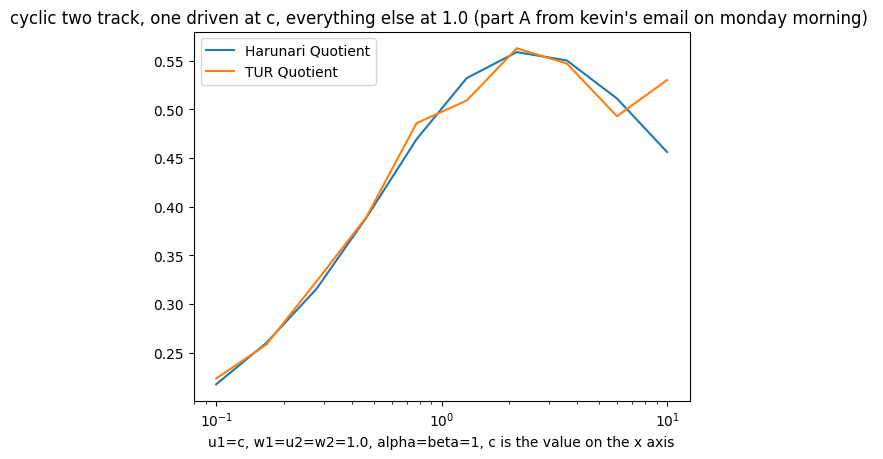

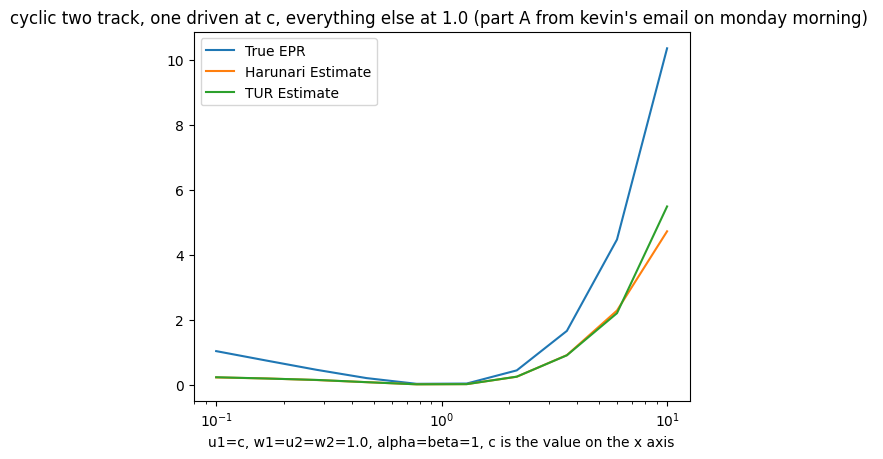

In [3]:
metastate_groups = {'A': [0,1], 'B': [2,3], 'C': [4,5]}
max_length = 10000000

rate_matrix_list_for_cpart=[]
true_eprs_cpart=[]
ks = 10 ** np.linspace(-1, 1, 10)
for k in ks:
    β = 1.0
    α = 1.0
    rate_matrix_list_for_cpart.append(generate_rate_matrix_for_parallel_tracks(α, β, k, 1.0, 1.0, 1.0))
    true_eprs_cpart.append(get_true_EPR_for_parallel_tracks(α, β, k, 1.0, 1.0, 1.0))


eprlistresult_cpart, list_of_tur_results_cpart, ratematrixlistresult_cpart = run_multiple_simulations(rate_matrix_list_for_cpart,metastate_groups,max_length)
print("eprlistresutl my system similar to kevins but now alpha=beta=1",rate_matrix_list_for_cpart)
print("tur esimate for mysystemsimilartokevinsystem but now alpha=beta=1: ", list_of_tur_results_cpart)
cpart_Harunari_quality_quotients= np.array(eprlistresult_cpart) / np.array(true_eprs_cpart)
cpart_TUR_quality_quotients=np.array(list_of_tur_results_cpart) / np.array(true_eprs_cpart)
print("mysustem simlar to kevin sytmem harunari quality quotients but now alpha=beta=1: ", cpart_Harunari_quality_quotients)


plt.plot(ks, cpart_Harunari_quality_quotients, label="Harunari Quotient")
plt.plot(ks, cpart_TUR_quality_quotients, label="TUR Quotient")
plt.xscale('log')
plt.title("cyclic two track, one driven at c, everything else at 1.0 (part A from kevin's email on monday morning) ")
plt.xlabel("u1=c, w1=u2=w2=1.0, alpha=beta=1, c is the value on the x axis")
plt.legend()
plt.show()

plt.plot(ks, true_eprs_cpart, label="True EPR")
plt.plot(ks, eprlistresult_cpart, label="Harunari Estimate")
plt.plot(ks, list_of_tur_results_cpart, label="TUR Estimate")
plt.xscale('log')
plt.xlabel("u1=c, w1=u2=w2=1.0, alpha=beta=1, c is the value on the x axis")
plt.title("cyclic two track, one driven at c, everything else at 1.0 (part A from kevin's email on monday morning) ")
plt.legend()
plt.show()

In [1]:
#ok somethings wrong with my TUR estimator...

def tur_testing_thingy_v3(trajectory, times, num_snippets=1000, state_mapping=None):
    """
    Splits the trajectory into num_snippets pieces, computes net forward transitions
    in the A→B→C→A cycle, and returns mean and variance.
    """
    import numpy as np
    import math
    from collections import Counter
    from itertools import groupby

    if state_mapping is None:
        state_mapping = {0: "A", 1: "A", 2: "B", 3: "B", 4: "C", 5: "C"}

    converted = [state_mapping[state] for state in trajectory]
    
    snippet_count = num_snippets
    snippet_length = len(converted) // snippet_count
    if snippet_length == 0:
        raise ValueError("Trajectory too short to split into num_snippets pieces.")

    net_transitions = []

    forward_cycle = [("A", "B"), ("B", "C"), ("C", "A")]
    backward_cycle = [(b, a) for (a, b) in forward_cycle]

    for i in range(snippet_count):
        start = i * snippet_length
        end = (i + 1) * snippet_length if i < snippet_count - 1 else len(converted)
        snippet = converted[start:end]

        coarse_trajectory = [key for key, _ in groupby(snippet)]
        transitions = [(coarse_trajectory[j], coarse_trajectory[j+1])
                       for j in range(len(coarse_trajectory) - 1)]

        transition_counts = Counter(transitions)

        net = 0
        for fwd in forward_cycle:
            net += transition_counts.get(fwd, 0)
        for bwd in backward_cycle:
            net -= transition_counts.get(bwd, 0)

        net_transitions.append(net)

    net_transitions = np.array(net_transitions)
    #mean_net = np.mean(net_transitions)
    #var_net = np.var(net_transitions)

    #print(f"Mean cyclic net forward transitions: {mean_net}")
    #print(f"Variance of cyclic net forward transitions: {var_net}")

    #result2 = 2*mean_net**2/var_net

    epsilon2=(np.mean(net_transitions**2) - np.mean(net_transitions)**2)/(np.mean(net_transitions)**2)

    #print("result2: ",result2)
    #print("epsilon2: ",epsilon2)

    return 2/(epsilon2*times[-1]/num_snippets)


In [14]:
#ok somethings wrong with my TUR estimator...

def tur_testing_thingy_v4(trajectory, times, num_snippets=1000, state_mapping=None):
    """
    Splits the trajectory into num_snippets pieces, computes net forward transitions
    in the A→B→C→A cycle, and returns mean and variance.
    """
    import numpy as np
    import math
    from collections import Counter
    from itertools import groupby

    if state_mapping is None:
        state_mapping = {0: "A", 1: "A", 2: "B", 3: "B", 4: "C", 5: "C"}

    converted = [state_mapping[state] for state in trajectory]
    
    snippet_count = num_snippets
    snippet_length = len(converted) // snippet_count
    if snippet_length == 0:
        raise ValueError("Trajectory too short to split into num_snippets pieces.")

    net_transitions = []
    time_for_snippets = []

    forward_cycle = [("A", "B"), ("B", "C"), ("C", "A")]
    backward_cycle = [(b, a) for (a, b) in forward_cycle]

    for i in range(snippet_count):
        start = i * snippet_length
        end = (i + 1) * snippet_length if i < snippet_count - 1 else len(converted)
        snippet = converted[start:end]

        coarse_trajectory = [key for key, _ in groupby(snippet)]
        transitions = [(coarse_trajectory[j], coarse_trajectory[j+1])
                       for j in range(len(coarse_trajectory) - 1)]

        transition_counts = Counter(transitions)

        net = 0
        for fwd in forward_cycle:
            net += transition_counts.get(fwd, 0)
        for bwd in backward_cycle:
            net -= transition_counts.get(bwd, 0)

        net_transitions.append(net)
        time_for_snippets.append(times[end]-times[start])

    net_transitions = np.array(net_transitions)
    time_for_snippets_as_np_array = np.array(time_for_snippets)
    mean_time_per_snippet = np.mean(time_for_snippets_as_np_array)
    epsilon2=(np.mean(net_transitions**2) - np.mean(net_transitions)**2)/(np.mean(net_transitions)**2)
    return 2/(epsilon2*mean_time_per_snippet)


In [15]:
metastate_groups = {'A': [0,1], 'B': [2,3], 'C': [4,5]}
max_length = 50000000
rate_matrix_temp=generate_rate_matrix_for_parallel_tracks(1.0, 1.0, 50*1.5, 50*0.5, 1.5, 0.5)

trajectory, times, waiting_times, time_in_metastates, transitions = simulate_single_trajectory(rate_matrix=rate_matrix_temp,metastate_groups=metastate_groups,  max_length=max_length,initial_state=0  )
tempStateMapping = {0: "A", 1: "A", 2: "B", 3: "B", 4: "C", 5: "C"}
tur_result=tur_testing_thingy_v4(trajectory,times,num_snippets=10000,state_mapping=tempStateMapping)
print("tur result for v4: ",tur_result)
get_true_EPR_for_parallel_tracks(1.0, 1.0, 50*1.5, 50*0.5, 1.5, 0.5)

Pre-computing transition data...
Starting optimized simulation with 6 states, 3 metastates
Initial state: 0
Core simulation completed in 2.59 seconds
Processing metastate transitions...
Analysis completed in 46.52 seconds

Simulation complete. Total time: 959001.58
Trajectory length: 50000000
Metastate A: 319633.66 total time, 16346651 visits, 0.02 avg per visit
  First few waiting times: ['0.005', '0.003', '0.038', '0.009', '0.011']
Metastate B: 319857.54 total time, 16345556 visits, 0.02 avg per visit
  First few waiting times: ['0.005', '0.001', '0.011', '0.003', '0.010']
Metastate C: 319510.38 total time, 16348828 visits, 0.02 avg per visit
  First few waiting times: ['0.000', '0.028', '0.016', '0.015', '0.003']
Total metastate transitions: 49041035
Total execution time: 49.12 seconds


IndexError: index 50000000 is out of bounds for axis 0 with size 50000000

In [18]:
import numpy as np
from collections import Counter

def tur_testing_thingy_v4_optimized(trajectory, times, num_snippets=1000, state_mapping=None):
    """
    Optimized version: Splits trajectory into num_snippets pieces, computes net forward transitions
    in the A→B→C→A cycle, and returns mean and variance.
    """
    if state_mapping is None:
        state_mapping = {0: "A", 1: "A", 2: "B", 3: "B", 4: "C", 5: "C"}

    # Vectorized state conversion
    trajectory_array = np.array(trajectory)
    converted = np.array([state_mapping[state] for state in trajectory_array])
    
    snippet_length = len(converted) // num_snippets
    if snippet_length == 0:
        raise ValueError("Trajectory too short to split into num_snippets pieces.")

    # Pre-allocate arrays
    net_transitions = np.zeros(num_snippets)
    time_for_snippets = np.zeros(num_snippets)
    
    # Precompute transition mappings for faster lookup
    forward_transitions = {("A", "B"): 1, ("B", "C"): 1, ("C", "A"): 1}
    backward_transitions = {("B", "A"): -1, ("C", "B"): -1, ("A", "C"): -1}
    
    for i in range(num_snippets):
        start = i * snippet_length
        end = (i + 1) * snippet_length if i < num_snippets - 1 else len(converted)
        snippet = converted[start:end]

        # More efficient coarse trajectory extraction
        if len(snippet) == 0:
            continue
            
        # Use numpy for change detection
        changes = np.concatenate(([True], snippet[1:] != snippet[:-1]))
        coarse_trajectory = snippet[changes]
        
        if len(coarse_trajectory) < 2:
            time_for_snippets[i] = times[end] - times[start]
            continue
        
        # Vectorized transition counting
        transitions = list(zip(coarse_trajectory[:-1], coarse_trajectory[1:]))
        
        net = 0
        for transition in transitions:
            net += forward_transitions.get(transition, 0)
            net += backward_transitions.get(transition, 0)
        
        net_transitions[i] = net
        time_for_snippets[i] = times[end] - times[start]

    # Vectorized statistics computation
    mean_time_per_snippet = np.mean(time_for_snippets)
    mean_net = np.mean(net_transitions)
    mean_net_squared = np.mean(net_transitions**2)
    
    # Avoid division by zero
    if mean_net == 0:
        return float('inf')
    
    epsilon2 = (mean_net_squared - mean_net**2) / (mean_net**2)
    
    if epsilon2 == 0:
        return float('inf')
    
    return 2 / (epsilon2 * mean_time_per_snippet)


def tur_testing_thingy_v4_ultra_optimized(trajectory, times, num_snippets=1000, state_mapping=None):
    """
    Ultra-optimized version using more advanced numpy operations.
    """
    if state_mapping is None:
        state_mapping = {0: "A", 1: "A", 2: "B", 3: "B", 4: "C", 5: "C"}

    # Vectorized state conversion using numpy array indexing
    traj_array = np.array(trajectory)
    # Create lookup array for faster mapping
    max_state = max(state_mapping.keys())
    state_lookup = np.array([''] * (max_state + 1), dtype='U1')
    for k, v in state_mapping.items():
        state_lookup[k] = v
    converted = state_lookup[traj_array]
    
    snippet_length = len(converted) // num_snippets
    if snippet_length == 0:
        raise ValueError("Trajectory too short to split into num_snippets pieces.")

    # Pre-allocate results
    net_transitions = np.zeros(num_snippets)
    time_diffs = np.zeros(num_snippets)
    
    # Precompute all snippet boundaries
    starts = np.arange(num_snippets) * snippet_length
    ends = np.minimum(starts + snippet_length, len(converted))
    ends[-1] = len(converted)  # Ensure last snippet goes to end
    
    for i in range(num_snippets):
        start, end = starts[i], ends[i]
        snippet = converted[start:end]
        
        if len(snippet) < 2:
            time_diffs[i] = times[min(end, len(times)-1)] - times[start]
            continue
        
        # Efficient coarse trajectory using numpy
        mask = np.concatenate(([True], snippet[1:] != snippet[:-1]))
        coarse_traj = snippet[mask]
        
        if len(coarse_traj) < 2:
            time_diffs[i] = times[min(end, len(times)-1)] - times[start]
            continue
        
        # Count transitions efficiently
        transitions = np.column_stack([coarse_traj[:-1], coarse_traj[1:]])
        
        # Vectorized counting using boolean indexing
        ab_count = np.sum((transitions[:, 0] == 'A') & (transitions[:, 1] == 'B'))
        bc_count = np.sum((transitions[:, 0] == 'B') & (transitions[:, 1] == 'C'))
        ca_count = np.sum((transitions[:, 0] == 'C') & (transitions[:, 1] == 'A'))
        
        ba_count = np.sum((transitions[:, 0] == 'B') & (transitions[:, 1] == 'A'))
        cb_count = np.sum((transitions[:, 0] == 'C') & (transitions[:, 1] == 'B'))
        ac_count = np.sum((transitions[:, 0] == 'A') & (transitions[:, 1] == 'C'))
        
        net_transitions[i] = (ab_count + bc_count + ca_count) - (ba_count + cb_count + ac_count)
        #time_diffs[i] = times[min(end, len(times)-1)] - times[start]

    # Final calculations
    #mean_time = np.mean(time_diffs)
    mean_net = np.mean(net_transitions)
    
    if mean_net == 0:
        return float('inf')
    
    epsilon2 = (np.var(net_transitions) + mean_net**2) / (mean_net**2) - 1
    
    if epsilon2 <= 0:
        return float('inf')
    
    return 2 / (epsilon2 * (times[-1]/num_snippets))

In [ ]:
metastate_groups = {'A': [0,1], 'B': [2,3], 'C': [4,5]}
max_length = 500000000
rate_matrix_temp=generate_rate_matrix_for_parallel_tracks(1.0, 1.0, 50*1.5, 50*0.5, 1.5, 0.5)

trajectory, times, waiting_times, time_in_metastates, transitions = simulate_single_trajectory(rate_matrix=rate_matrix_temp,metastate_groups=metastate_groups,  max_length=max_length,initial_state=0  )
tempStateMapping = {0: "A", 1: "A", 2: "B", 3: "B", 4: "C", 5: "C"}
tur_result=tur_testing_thingy_v4_ultra_optimized(trajectory,times,num_snippets=100000,state_mapping=tempStateMapping)
print("tur result for v4: ",tur_result)
get_true_EPR_for_parallel_tracks(1.0, 1.0, 50*1.5, 50*0.5, 1.5, 0.5)

Running Markov chain simulation...
rate matrix:  [[-11.09090909   0.90909091   1.           0.          10.
    0.        ]
 [  0.09090909  -2.90909091   0.           1.           0.
    1.        ]
 [ 10.           0.         -11.09090909   0.90909091   1.
    0.        ]
 [  0.           1.           0.09090909  -2.90909091   0.
    1.        ]
 [  1.           0.          10.           0.         -11.09090909
    0.90909091]
 [  0.           1.           0.           1.           0.09090909
   -2.90909091]]
Pre-computing transition data...
Starting optimized simulation with 6 states, 3 metastates
Initial state: 0
Core simulation completed in 0.65 seconds
Processing metastate transitions...
Analysis completed in 13.79 seconds

Simulation complete. Total time: 966351.84
Trajectory length: 10000000
Metastate A: 322162.70 total time, 3279529 visits, 0.10 avg per visit
  First few waiting times: ['0.045', '0.120', '0.094', '0.292', '0.025']
Metastate B: 322202.54 total time, 3280110 visi

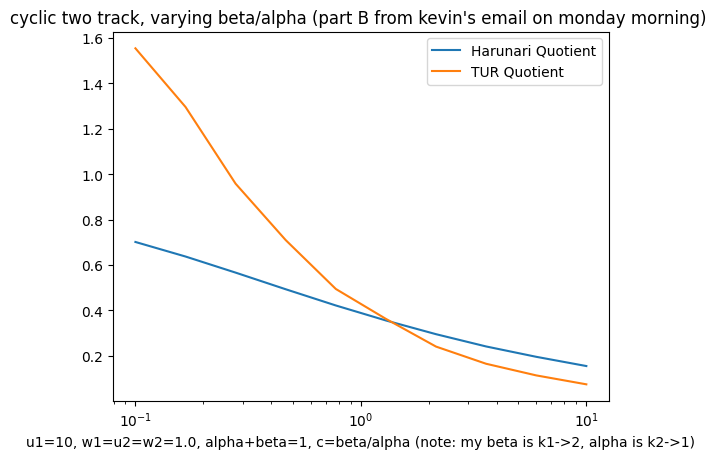

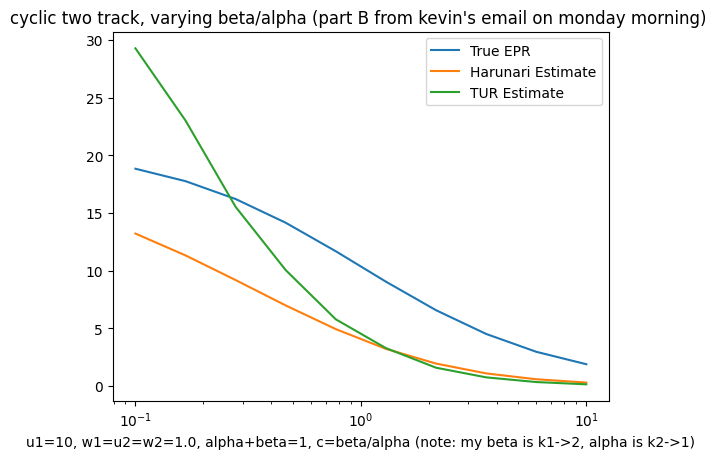

In [6]:
metastate_groups = {'A': [0,1], 'B': [2,3], 'C': [4,5]}
max_length = 10000000

rate_matrix_list_for_cpart=[]
true_eprs_cpart=[]
ks = 10 ** np.linspace(-1, 1, 10)
for k in ks:
    β = k/(1+k)
    α = 1.0-β
    rate_matrix_list_for_cpart.append(generate_rate_matrix_for_parallel_tracks(α, β, 10.0, 1.0, 1.0, 1.0))
    true_eprs_cpart.append(get_true_EPR_for_parallel_tracks(α, β, 10.0, 1.0, 1.0, 1.0))


eprlistresult_cpart, list_of_tur_results_cpart, ratematrixlistresult_cpart = run_multiple_simulations(rate_matrix_list_for_cpart,metastate_groups,max_length)
print("eprlistresutl my system similar to kevins but now alpha=beta=1",rate_matrix_list_for_cpart)
print("tur esimate for mysystemsimilartokevinsystem but now alpha=beta=1: ", list_of_tur_results_cpart)
cpart_Harunari_quality_quotients= np.array(eprlistresult_cpart) / np.array(true_eprs_cpart)
cpart_TUR_quality_quotients=np.array(list_of_tur_results_cpart) / np.array(true_eprs_cpart)
print("mysustem simlar to kevin sytmem harunari quality quotients but now alpha=beta=1: ", cpart_Harunari_quality_quotients)


plt.plot(ks, cpart_Harunari_quality_quotients, label="Harunari Quotient")
plt.plot(ks, cpart_TUR_quality_quotients, label="TUR Quotient")
plt.xscale('log')
plt.xlabel("u1=10, w1=u2=w2=1.0, alpha+beta=1, c=beta/alpha (note: my beta is k1->2, alpha is k2->1)")
plt.title("cyclic two track, varying beta/alpha (part B from kevin's email on monday morning) ")
plt.legend()
plt.show()

plt.plot(ks, true_eprs_cpart, label="True EPR")
plt.plot(ks, eprlistresult_cpart, label="Harunari Estimate")
plt.plot(ks, list_of_tur_results_cpart, label="TUR Estimate")
plt.xscale('log')
plt.xlabel("u1=10, w1=u2=w2=1.0, alpha+beta=1, c=beta/alpha (note: my beta is k1->2, alpha is k2->1)")
plt.title("cyclic two track, varying beta/alpha (part B from kevin's email on monday morning) ")
plt.legend()
plt.show()

In [ ]:
metastate_groups = {'A': [0,1], 'B': [2,3], 'C': [4,5]}
max_length = 500000000
rate_matrix_temp=generate_rate_matrix_for_parallel_tracks(1.0, 1.0, 50*1.5, 50*0.5, 1.5, 0.5)

trajectory, times, waiting_times, time_in_metastates, transitions = simulate_single_trajectory(rate_matrix=rate_matrix_temp,metastate_groups=metastate_groups,  max_length=max_length,initial_state=0  )
tempStateMapping = {0: "A", 1: "A", 2: "B", 3: "B", 4: "C", 5: "C"}
tur_result=tur_testing_thingy_v3(trajectory,times,num_snippets=100000,state_mapping=tempStateMapping)
print("tur result: ",tur_result)
get_true_EPR_for_parallel_tracks(1.0, 1.0, 50*1.5, 50*0.5, 1.5, 0.5)

Pre-computing transition data...
Starting optimized simulation with 6 states, 3 metastates
Initial state: 0
Core simulation completed in 32.52 seconds
Processing metastate transitions...


KeyboardInterrupt: 

Running Markov chain simulation...
rate matrix:  [[-1.2   1.    0.05  0.    0.15  0.  ]
 [ 1.   -3.    0.    0.5   0.    1.5 ]
 [ 0.15  0.   -1.2   1.    0.05  0.  ]
 [ 0.    1.5   1.   -3.    0.    0.5 ]
 [ 0.05  0.    0.15  0.   -1.2   1.  ]
 [ 0.    0.5   0.    1.5   1.   -3.  ]]
Pre-computing transition data...
Starting optimized simulation with 6 states, 3 metastates
Initial state: 0
Core simulation completed in 5.69 seconds
Processing metastate transitions...
Analysis completed in 49.05 seconds

Simulation complete. Total time: 47622048.29
Trajectory length: 100000000
Metastate A: 15873268.22 total time, 17462346 visits, 0.91 avg per visit
  First few waiting times: ['2.114', '0.478', '0.612', '0.435', '0.333']
Metastate B: 15875152.72 total time, 17463607 visits, 0.91 avg per visit
  First few waiting times: ['0.227', '0.514', '0.146', '0.110', '0.062']
Metastate C: 15873627.35 total time, 17462789 visits, 0.91 avg per visit
  First few waiting times: ['0.683', '0.576', '0.311',

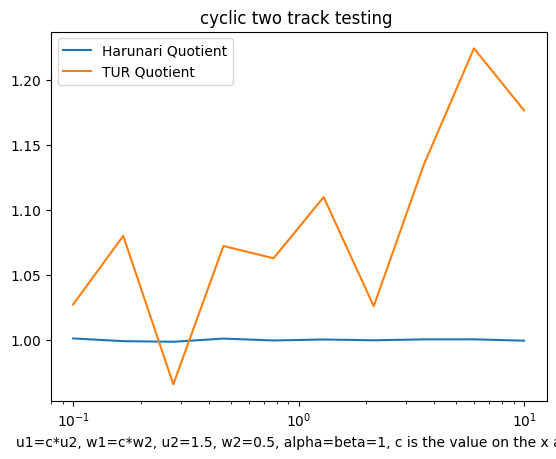

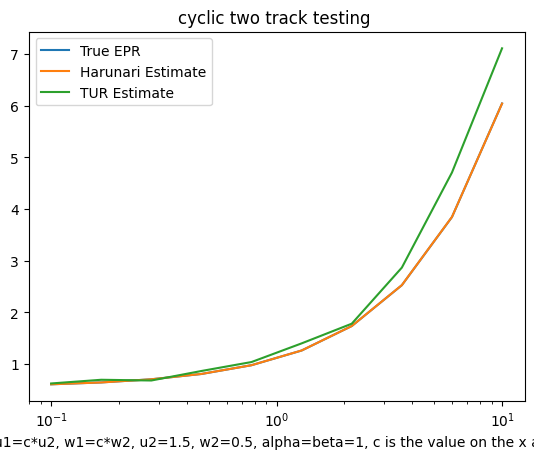

In [5]:
metastate_groups = {'A': [0,1], 'B': [2,3], 'C': [4,5]}
max_length = 100000000

rate_matrix_list_for_cpart=[]
true_eprs_cpart=[]
ks = 10 ** np.linspace(-1, 1, 10)
for k in ks:
    β = 1.0
    α = 1.0
    rate_matrix_list_for_cpart.append(generate_rate_matrix_for_parallel_tracks(α, β, k*1.5, k*0.5, 1.5, 0.5))
    true_eprs_cpart.append(get_true_EPR_for_parallel_tracks(α, β, k*1.5, k*0.5, 1.5, 0.5))


eprlistresult_cpart, list_of_tur_results_cpart, ratematrixlistresult_cpart = run_multiple_simulations(rate_matrix_list_for_cpart,metastate_groups,max_length)
print("eprlistresutl my system similar to kevins but now alpha=beta=1",rate_matrix_list_for_cpart)
print("tur esimate for mysystemsimilartokevinsystem but now alpha=beta=1: ", list_of_tur_results_cpart)
cpart_Harunari_quality_quotients= np.array(eprlistresult_cpart) / np.array(true_eprs_cpart)
cpart_TUR_quality_quotients=np.array(list_of_tur_results_cpart) / np.array(true_eprs_cpart)
print("mysustem simlar to kevin sytmem harunari quality quotients but now alpha=beta=1: ", cpart_Harunari_quality_quotients)


plt.plot(ks, cpart_Harunari_quality_quotients, label="Harunari Quotient")
plt.plot(ks, cpart_TUR_quality_quotients, label="TUR Quotient")
plt.xscale('log')
plt.title("cyclic two track testing ")
plt.xlabel("u1=c*u2, w1=c*w2, u2=1.5, w2=0.5, alpha=beta=1, c is the value on the x axis")
plt.legend()
plt.show()

plt.plot(ks, true_eprs_cpart, label="True EPR")
plt.plot(ks, eprlistresult_cpart, label="Harunari Estimate")
plt.plot(ks, list_of_tur_results_cpart, label="TUR Estimate")
plt.xscale('log')
plt.title("cyclic two track testing ")
plt.xlabel("u1=c*u2, w1=c*w2, u2=1.5, w2=0.5, alpha=beta=1, c is the value on the x axis")
plt.legend()
plt.show()

Running Markov chain simulation...
rate matrix:  [[-1.2   1.    0.05  0.    0.15  0.  ]
 [ 1.   -3.    0.    0.5   0.    1.5 ]
 [ 0.15  0.   -1.2   1.    0.05  0.  ]
 [ 0.    1.5   1.   -3.    0.    0.5 ]
 [ 0.05  0.    0.15  0.   -1.2   1.  ]
 [ 0.    0.5   0.    1.5   1.   -3.  ]]
Pre-computing transition data...
Starting optimized simulation with 6 states, 3 metastates
Initial state: 0
Core simulation completed in 8.62 seconds
Processing metastate transitions...
Analysis completed in 57.36 seconds

Simulation complete. Total time: 47615233.41
Trajectory length: 100000000
Metastate A: 15876673.22 total time, 17461796 visits, 0.91 avg per visit
  First few waiting times: ['2.592', '0.043', '0.295', '0.029', '1.263']
Metastate B: 15871596.49 total time, 17462717 visits, 0.91 avg per visit
  First few waiting times: ['0.943', '0.646', '0.021', '4.616', '0.020']
Metastate C: 15866963.63 total time, 17461182 visits, 0.91 avg per visit
  First few waiting times: ['1.287', '0.291', '1.751',

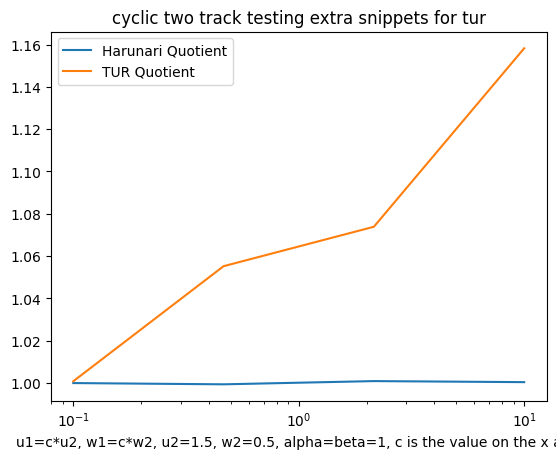

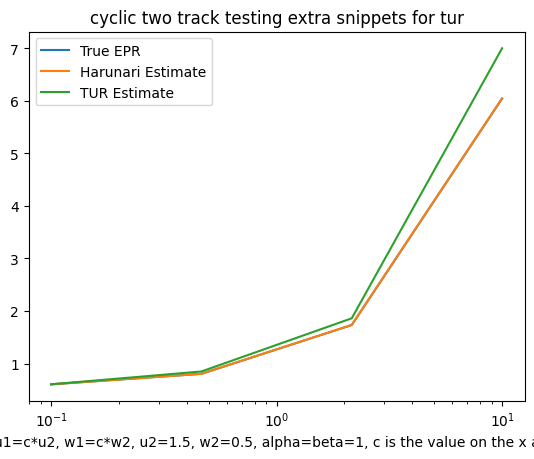

In [9]:
metastate_groups = {'A': [0,1], 'B': [2,3], 'C': [4,5]}
max_length = 100000000

rate_matrix_list_for_cpart=[]
true_eprs_cpart=[]
ks = 10 ** np.linspace(-1, 1, 4)
for k in ks:
    β = 1.0
    α = 1.0
    rate_matrix_list_for_cpart.append(generate_rate_matrix_for_parallel_tracks(α, β, k*1.5, k*0.5, 1.5, 0.5))
    true_eprs_cpart.append(get_true_EPR_for_parallel_tracks(α, β, k*1.5, k*0.5, 1.5, 0.5))


eprlistresult_cpart, list_of_tur_results_cpart, ratematrixlistresult_cpart = run_multiple_simulations(rate_matrix_list_for_cpart,metastate_groups,max_length,num_snippets_for_TUR=10000)
print("eprlistresutl my system similar to kevins but now alpha=beta=1",rate_matrix_list_for_cpart)
print("tur esimate for mysystemsimilartokevinsystem but now alpha=beta=1: ", list_of_tur_results_cpart)
cpart_Harunari_quality_quotients= np.array(eprlistresult_cpart) / np.array(true_eprs_cpart)
cpart_TUR_quality_quotients=np.array(list_of_tur_results_cpart) / np.array(true_eprs_cpart)
print("mysustem simlar to kevin sytmem harunari quality quotients but now alpha=beta=1: ", cpart_Harunari_quality_quotients)


plt.plot(ks, cpart_Harunari_quality_quotients, label="Harunari Quotient")
plt.plot(ks, cpart_TUR_quality_quotients, label="TUR Quotient")
plt.xscale('log')
plt.title("cyclic two track testing extra snippets for tur")
plt.xlabel("u1=c*u2, w1=c*w2, u2=1.5, w2=0.5, alpha=beta=1, c is the value on the x axis")
plt.legend()
plt.show()

plt.plot(ks, true_eprs_cpart, label="True EPR")
plt.plot(ks, eprlistresult_cpart, label="Harunari Estimate")
plt.plot(ks, list_of_tur_results_cpart, label="TUR Estimate")
plt.xscale('log')
plt.title("cyclic two track testing extra snippets for tur")
plt.xlabel("u1=c*u2, w1=c*w2, u2=1.5, w2=0.5, alpha=beta=1, c is the value on the x axis")
plt.legend()
plt.show()

In [ ]:
metastate_groups = {'A': [0,1], 'B': [2,3], 'C': [4,5]}
max_length = 100000000

rate_matrix_list_for_cpart=[]
true_eprs_cpart=[]
#ks = 10 ** np.linspace(-1, 1, 4)
ks = 10 ** 1
for k in ks:
    β = 1.0
    α = 1.0
    rate_matrix_list_for_cpart.append(generate_rate_matrix_for_parallel_tracks(α, β, k*1.5, k*0.5, 1.5, 0.5))
    true_eprs_cpart.append(get_true_EPR_for_parallel_tracks(α, β, k*1.5, k*0.5, 1.5, 0.5))


eprlistresult_cpart, list_of_tur_results_cpart, ratematrixlistresult_cpart = run_multiple_simulations(rate_matrix_list_for_cpart,metastate_groups,max_length,num_snippets_for_TUR=100000)
print("eprlistresutl my system similar to kevins but now alpha=beta=1",rate_matrix_list_for_cpart)
print("tur esimate for mysystemsimilartokevinsystem but now alpha=beta=1: ", list_of_tur_results_cpart)
cpart_Harunari_quality_quotients= np.array(eprlistresult_cpart) / np.array(true_eprs_cpart)
cpart_TUR_quality_quotients=np.array(list_of_tur_results_cpart) / np.array(true_eprs_cpart)
print("mysustem simlar to kevin sytmem harunari quality quotients but now alpha=beta=1: ", cpart_Harunari_quality_quotients)


plt.plot(ks, cpart_Harunari_quality_quotients, label="Harunari Quotient")
plt.plot(ks, cpart_TUR_quality_quotients, label="TUR Quotient")
plt.xscale('log')
plt.title("cyclic two track testing extra snippets for tur")
plt.xlabel("u1=c*u2, w1=c*w2, u2=1.5, w2=0.5, alpha=beta=1, c is the value on the x axis")
plt.legend()
plt.show()

plt.plot(ks, true_eprs_cpart, label="True EPR")
plt.plot(ks, eprlistresult_cpart, label="Harunari Estimate")
plt.plot(ks, list_of_tur_results_cpart, label="TUR Estimate")
plt.xscale('log')
plt.title("cyclic two track testing extra snippets for tur")
plt.xlabel("u1=c*u2, w1=c*w2, u2=1.5, w2=0.5, alpha=beta=1, c is the value on the x axis")
plt.legend()
plt.show()

In [17]:
def generate_mysystem_5state_matrix(alpha, beta, kB, kF):
    rate_matrix = np.array([
        [-(kF+beta+alpha),  beta,   alpha, kB,   0.0000],
        [  alpha, -(kB+beta+alpha),  beta,   0.0000, kF],
        [ beta,   alpha, -(alpha+beta),   0.0000,   0.0000],
        [kF,   0.0000,   0.0000, -(kB+kF), kB],
        [  0.0000, kB,   0.0000, kF, -(kB+kF)],
    ])
    return rate_matrix

In [21]:
print(generate_mysystem_5state_matrix(1.0,0.05, 1.0, 1.0))

[[-2.05  0.05  1.    1.    0.  ]
 [ 1.   -2.05  0.05  0.    1.  ]
 [ 0.05  1.   -1.05  0.    0.  ]
 [ 1.    0.    0.   -2.    1.  ]
 [ 0.    1.    0.    1.   -2.  ]]
